In [1]:
# No imports allowed besides these.
from collections import Counter, defaultdict
from itertools import chain, combinations
from nltk.corpus import stopwords
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from scipy.sparse import csr_matrix
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import tarfile
import urllib.request

In [2]:
def download_data():
    """ Download and unzip data.
    DONE ALREADY.
    """
    url = 'https://www.dropbox.com/s/xk4glpk61q3qrg2/imdb.tgz?dl=1'
    urllib.request.urlretrieve(url, 'imdb.tgz')
    tar = tarfile.open("imdb.tgz")
    tar.extractall()
    tar.close()

In [3]:
def read_data(path):
    """
    Walks all subdirectories of this path and reads all
    the text files and labels.
    DONE ALREADY.
    Params:
      path....path to files
    Returns:
      docs.....list of strings, one per document
      labels...list of ints, 1=positive, 0=negative label.
               Inferred from file path (i.e., if it contains
               'pos', it is 1, else 0)
    """
    fnames = sorted([f for f in glob.glob(os.path.join(path, 'pos', '*.txt'))])
    data = [(1, open(f).readlines()[0]) for f in sorted(fnames)]
    fnames = sorted([f for f in glob.glob(os.path.join(path, 'neg', '*.txt'))])
    data += [(0, open(f).readlines()[0]) for f in sorted(fnames)]
    data = sorted(data, key=lambda x: x[1])
    return np.array([d[1] for d in data]), np.array([d[0] for d in data])

In [4]:
def tokenize(doc, keep_internal_punct=False):
    """
    Tokenize a string.
    The string should be converted to lowercase.
    If keep_internal_punct is False, then return only the alphanumerics (letters, numbers and underscore).
    If keep_internal_punct is True, then also retain punctuation that
    is inside of a word. E.g., in the example below, the token "isn't"
    is maintained when keep_internal_punct=True; otherwise, it is
    split into "isn" and "t" tokens.
    Params:
      doc....a string.
      keep_internal_punct...see above
    Returns:
      a numpy array containing the resulting tokens.
    >>> tokenize(" Hi there! Isn't this fun?", keep_internal_punct=False)
    array(['hi', 'there', 'isn', 't', 'this', 'fun'], 
          dtype='<U5')
    >>> tokenize("Hi there! Isn't this fun? ", keep_internal_punct=True)
    array(['hi', 'there', "isn't", 'this', 'fun'], 
          dtype='<U5')
    """
    w=""
    stopset = set(stopwords.words('english'))
    punch = string.punctuation.replace("_","")
    if(keep_internal_punct==False):
        result = re.sub("\W+"," ",doc.lower()).split()
        result = [w for w in result if not w in stopset]
        final = np.array(result)
    else:
        for i in doc.split():
            #punch = punctuation.replace("_","")
            r = i.strip(punch)
            w = w + r + " "
        result = re.sub("^\W+"," ",w.lower()).split()
        result = [w for w in result if not w in stopset]
        final = np.array(result)
    return final.astype('U')


In [5]:
def token_features(tokens, feats):
    """
    Add features for each token. The feature name
    is pre-pended with the string "token=".
    Note that the feats dict is modified in place,
    so there is no return value.
    Params:
      tokens...array of token strings from a document.
      feats....dict from feature name to frequency
    Returns:
      nothing; feats is modified in place.
    >>> feats = defaultdict(lambda: 0)
    >>> token_features(['hi', 'there', 'hi'], feats)
    >>> sorted(feats.items())
    [('token=hi', 2), ('token=there', 1)]
    """
    c=0
    for i in tokens:
        c=0
        for j in tokens:
            if i==j:
                c=c+1
        feats["token="+i] = c

In [27]:
def token_pair_features(tokens, feats, k=3):
    """
    Compute features indicating that two words occur near
    each other within a window of size k.
    For example [a, b, c, d] with k=3 will consider the
    windows: [a,b,c], [b,c,d]. In the first window,
    a_b, a_c, and b_c appear; in the second window,
    b_c, c_d, and b_d appear. This example is in the
    doctest below.
    Note that the order of the tokens in the feature name
    matches the order in which they appear in the document.
    (e.g., a__b, not b__a)
    Params:
      tokens....array of token strings from a document.
      feats.....a dict from feature to value
      k.........the window size (3 by default)
    Returns:
      nothing; feats is modified in place.
    >>> feats = defaultdict(lambda: 0)
    >>> token_pair_features(np.array(['a', 'b', 'c', 'd']), feats)
    >>> sorted(feats.items())
    [('token_pair=a__b', 1), ('token_pair=a__c', 1), ('token_pair=b__c', 2), ('token_pair=b__d', 1), ('token_pair=c__d', 1)]
    """
    
    #tpf = []
    #r = len(tokens)-k+1
    #for x in range(r):
    #    for y in combinations(tokens[x:x+k],2):
    #   tpf.extend(["=".join(["token_pair","__".join(y)])])
    w=[]
    #z={}
    for i in range(len(tokens)):
        c=0
        j=i
        if i+k-1<len(tokens):
            while(c<k):
                w.append(tokens[j])
                c=c+1
                j=j+1
        else:
            break
        combination(w,feats)
        #print(i)
        #z[i]=w
        #print(w)
        w.clear()
    #print(z)"""
        
def combination(w,feats): 
    #for i in combinations(w,2):
    #        token = [i[0]+"__"+i[1]]
    #        for j in token:
    #            for k in token:
    #                if j==k:
    #                    c=c+1
    #            feats["token="+j] = c
            #feats[token] = feats[token]+1
    #print(token)
    #print(feats)
    for i in combinations(w,2):
        parts = [i[0]+"__"+i[1]]
        #print(parts)
        #feats[parts]=feats[parts]+1
        for j in parts:
            if "token_pair="+j not in feats:
                feats["token_pair="+j] = 1
            elif "token_pair="+j in feats:
                feats["token_pair="+j] = feats["token_pair="+j] + 1
    #print(feats)
    #for i in parts:
    #    c=0
    #    for j in parts:
    #        if i==j:
    #            c=c+1
    #    feats["token_pair="+i] = c
    #print()"""
    


In [28]:
neg_words = set(['bad', 'hate', 'horrible', 'worst', 'boring'])
pos_words = set(['awesome', 'amazing', 'best', 'good', 'great', 'love', 'wonderful'])

In [29]:
neg_words

{'bad', 'boring', 'hate', 'horrible', 'worst'}

In [30]:
def lexicon_features(tokens, feats):
    """
    Add features indicating how many time a token appears that matches either
    the neg_words or pos_words (defined above). The matching should ignore
    case.
    Params:
      tokens...array of token strings from a document.
      feats....dict from feature name to frequency
    Returns:
      nothing; feats is modified in place.
    In this example, 'LOVE' and 'great' match the pos_words,
    and 'boring' matches the neg_words list.
    >>> feats = defaultdict(lambda: 0)
    >>> lexicon_features(np.array(['i', 'LOVE', 'this', 'great', 'boring', 'movie']), feats)
    >>> sorted(feats.items())
    [('neg_words', 1), ('pos_words', 2)]
    """
    ###TODO
    feats['pos_words'] = 0
    feats['neg_words'] = 0
    for i in tokens:
        for j in pos_words:
            if(i.lower()==j.lower()):
                feats['pos_words'] = feats['pos_words']+1
                
    for i in tokens:
        for j in neg_words:
            if(i.lower()==j.lower()):
                feats['neg_words'] = feats['neg_words']+1
    pass

In [31]:
def featurize(tokens, feature_fns):
    """
    Compute all features for a list of tokens from
    a single document.
    Params:
      tokens........array of token strings from a document.
      feature_fns...a list of functions, one per feature
    Returns:
      list of (feature, value) tuples, SORTED alphabetically
      by the feature name.
    >>> feats = featurize(np.array(['i', 'LOVE', 'this', 'great', 'movie']), [token_features, lexicon_features])
    >>> feats
    [('neg_words', 0), ('pos_words', 2), ('token=LOVE', 1), ('token=great', 1), ('token=i', 1), ('token=movie', 1), ('token=this', 1)]
    """
    ###TODO
    feats={}
    w=[]
    for i in feature_fns:
        i(tokens,feats)
        #print(feats)
    for i,j in feats.items():
        s=(i,j)
        #print(s)
        w.append(s)
    return(sorted(w))

In [32]:
def vectorize(docs, feature_fns, min_freq, vocab=None):
    """
    Given the tokens for a set of documents, create a sparse
    feature matrix, where each row represents a document, and
    each column represents a feature.
    Params:
      tokens_list...a list of lists; each sublist is an
                    array of token strings from a document.
      feature_fns...a list of functions, one per feature
      min_freq......Remove features that do not appear in
                    at least min_freq different documents.
    Returns:
      - a csr_matrix: See https://goo.gl/f5TiF1 for documentation.
      This is a sparse matrix (zero values are not stored).
      - vocab: a dict from feature name to column index. NOTE
      that the columns are sorted alphabetically (so, the feature
      "token=great" is column 0 and "token=horrible" is column 1
      because "great" < "horrible" alphabetically),
    >>> docs = ["Isn't this movie great?", "Horrible, horrible movie"]
    >>> tokens_list = [tokenize(d) for d in docs]
    >>> feature_fns = [token_features]
    >>> X, vocab = vectorize(tokens_list, feature_fns, min_freq=1)
    >>> type(X)
    <class 'scipy.sparse.csr.csr_matrix'>
    >>> X.toarray()
    array([[1, 0, 1, 1, 1, 1],
           [0, 2, 0, 1, 0, 0]], dtype=int64)
    >>> sorted(vocab.items(), key=lambda x: x[1])
    [('token=great', 0), ('token=horrible', 1), ('token=isn', 2), ('token=movie', 3), ('token=t', 4), ('token=this', 5)]
    """
    ###TODO
    vectorizer = TfidfVectorizer()
    #tfidf = TfidfTransformer(norm="l2")
    if vocab != None:
        mat = vectorizer.fit_transform(docs)
        return mat,vocab
    elif vocab == None:
        new_vocab = defaultdict(list)
        doc = {}
        for i in range(len(tokens_list)):
            r1 = dict(featurize((tokens_list[i]),feature_fns))
            #r1 = dict(r)
            doc[i]=r1
            for j in r1:
                #print(j)
                new_vocab[j].append(i)
        #print(new_vocab)
        #vocab1 = {}
        vocab1 = {}
        index = 0
        for i in sorted(new_vocab):
            if(len(new_vocab[i])>=min_freq):
                vocab1[i]=index
                index = index + 1
        #print(vocab1['token=great'])
        #print(vocab1)
        mat = vectorizer.fit_transform(docs)
        #print(result)
        return mat,vocab1

In [33]:
docs = ["Isn't this movie great?", "Horrible, horrible movie"]
tokens_list = [tokenize(d) for d in docs]
feature_fns = [token_features]
X, vocab = vectorize(docs, feature_fns, min_freq=1)
type(X)
X.toarray()

array([[0.53404633, 0.        , 0.53404633, 0.37997836, 0.53404633],
       [0.        , 0.94215562, 0.        , 0.33517574, 0.        ]])

In [34]:
def accuracy_score(truth, predicted):
    """ Compute accuracy of predictions.
    DONE ALREADY
    Params:
      truth.......array of true labels (0 or 1)
      predicted...array of predicted labels (0 or 1)
    """
    return len(np.where(truth==predicted)[0]) / len(truth)

In [35]:
def cross_validation_accuracy(clf, X, labels, k):
    ###TODO
    cv = KFold(n_splits = k,random_state=len(labels))
    accuracies=[]
    for train_ind, test_ind in cv.split(X):
        #train, test = X[train_ind], X[test_ind]
        clf.fit(X[train_ind],labels[train_ind])
        predictions = clf.predict(X[test_ind])
        accuracies.append(accuracy_score(labels[test_ind], predictions))
    average = np.mean(np.array(accuracies))
    #print(avergae)
    return average
    pass

In [36]:
def eval_all_combinations(docs, labels, punct_vals,feature_fns, min_freqs):
    feats = []
    for x in range(1,len(feature_fns)+1):
        for i in combinations(feature_fns,x):
            feats.append(i)
    final = []
    for pv in punct_vals:
        token = []
        for d in docs:
            token.append(tokenize(d,pv))
        for m in min_freqs:
            for f in feats:
                X, vocab = vectorize(docs, f, m)
                #model = LogisticRegression()
                zo=cross_validation_accuracy(LogisticRegression(), X, labels, 5)
                #t={}
                #t['punct'] = pv
                #t['features'] = f
                #t['min_freq'] = m
                #t['accuracy'] = zo
                #final.append(t)
                final.append({'punct' : pv, 'features' : f, 'min_freq' : m, 'accuracy' : zo})
    srt = sorted(final,key=lambda x:(x['accuracy'],x['min_freq']), reverse=True)
    return srt

In [37]:
def plot_sorted_accuracies(results):
    ###TODO
    a = []
    for i in results:
        a.append(i["accuracy"])
    srt = sorted(a)
    plt.plot(srt)
    plt.xlabel("setting")
    plt.ylabel("accuracy")
    plt.savefig("accuracies.png")
    pass

In [38]:
def mean_accuracy_per_setting(results):
    ###TODO
    accuracy = []
    f = []
    for i in results:
        accuracy.append(("features", i['features']))
        accuracy.append(("min_freq", i['min_freq']))
        accuracy.append(("punct", i['punct']))
    for i in set(accuracy):
        acc = []
        for j in results:
            if j[i[0]] == i[1]:
                acc.append(j['accuracy'])
                #print(acc)
        if 'features' in i[0]:
            fname = [k.__name__ for k in i[1]]
            f.append((np.mean(acc), str(("features=" + " ".join(fname)))))
        else:
            f.append((np.mean(acc), (i[0] + "=" + str(i[1]))))
    srt = sorted(f, key=lambda x: -x[0])
    return srt
    #accuracy = []
    #f = []
    #for i in results:
    #    f["min_freq="+str(result["min_freq"])] = (temp["min_freq="+str(result)])

In [39]:
def fit_best_classifier(docs, labels, best_result):
    ###TODO
    t=[]
    minfreq=best_result["min_freq"]
    features = best_result["features"]
    punct = best_result["punct"]
    for i in docs:
        t.append(tokenize(i,punct))
    X,v = vectorize(docs,features,minfreq)
    clf=LogisticRegression()
    clf.fit(X,labels)
    return clf,v

In [40]:
def top_coefs(clf, label, n, vocab):
    ###TODO
    r=[]
    co = clf.coef_[0]
    #going for neg
    if label == 0:
        for i in vocab:
            r.append((i,co[vocab[i]]))
        sort = sorted(r,key=lambda x: x[1])
        r1 = []
        for i in sort[:n]:
            r1.append((i[0],-1*i[1]))
        return r1
    
    #going for pos
    elif label == 1:
        for i in vocab:
            r.append((i,co[vocab[i]]))
        return sorted(r,key=lambda x: -x[1])[:n]

In [41]:
def parse_test_data(best_result, vocab):
    ###TODO
    list_t=[]
    test_docs, test_labels = read_data(os.path.join('data','test'))
    f=best_result["features"]
    minf=best_result["min_freq"]
    punch = best_result["punct"]
    for i in test_docs:
        list_t.append(tokenize(i,punch))
    X_test,new_vocab = vectorize(test_docs,f,minf,vocab)
    return test_docs,test_labels,X_test

In [42]:
def print_top_misclassified(test_docs, test_labels, X_test, clf, n):
    ###TODO
    new_list=[]
    p_1=clf.predict_proba(X_test)
    p = clf.predict(X_test)
    for i in range(0,len(p)):
        d={}
        if(p[i] != test_labels[i]):
            if p[i] == 0:
                d['test'] = test_docs[i]
                d['true'] = p_1[i][0]
                d['predicted'] = p[i]
                d['label'] = test_labels[i]
            else:
                d['test'] = test_docs[i]
                d['true'] = p_1[i][1]
                d['predicted'] = p[i]
                d['label'] = test_labels[i]
            new_list.append(d)
    new_list = sorted(new_list,key=lambda x:(-x['true']))[:n]
    for i in new_list:
        print('truth=%d predicted=%d proba=%.6f'%(i['label'],i['predicted'],i['true']))
        print(i['test']+"\n")

best cross-validation result:
{'punct': True, 'features': (<function token_features at 0x00000279BE3C7620>,), 'min_freq': 10, 'accuracy': 0.6875000000000001}
worst cross-validation result:
{'punct': False, 'features': (<function token_features at 0x00000279BE3C7620>, <function token_pair_features at 0x00000279BE49AEA0>, <function lexicon_features at 0x00000279BE4A3158>), 'min_freq': 2, 'accuracy': 0.6875000000000001}

Mean Accuracies per Setting:
features=token_features token_pair_features: 0.68750
features=token_features: 0.68750
features=lexicon_features: 0.68750
min_freq=5: 0.68750
features=token_features token_pair_features lexicon_features: 0.68750
features=token_pair_features: 0.68750
features=token_features lexicon_features: 0.68750
min_freq=2: 0.68750
punct=False: 0.68750
features=token_pair_features lexicon_features: 0.68750
min_freq=10: 0.68750
punct=True: 0.68750

TOP COEFFICIENTS PER CLASS:
negative words:


positive words:



ValueError: X has 10807 features per sample; expecting 10681

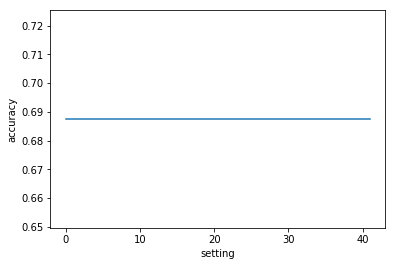

In [43]:
def main():
    """
    Put it all together.
    ALREADY DONE.
    """
    feature_fns = [token_features, token_pair_features, lexicon_features]
    # Download and read data.
    download_data()
    docs, labels = read_data(os.path.join('data', 'train'))
    # Evaluate accuracy of many combinations
    # of tokenization/featurization.
    results = eval_all_combinations(docs, labels,
                                    [True, False],
                                    feature_fns,
                                    [2,5,10])
    # Print information about these results.
    best_result = results[0]
    worst_result = results[-1]
    print('best cross-validation result:\n%s' % str(best_result))
    print('worst cross-validation result:\n%s' % str(worst_result))
    plot_sorted_accuracies(results)
    print('\nMean Accuracies per Setting:')
    print('\n'.join(['%s: %.5f' % (s,v) for v,s in mean_accuracy_per_setting(results)]))

    # Fit best classifier.
    clf, vocab = fit_best_classifier(docs, labels, results[0])

    # Print top coefficients per class.
    print('\nTOP COEFFICIENTS PER CLASS:')
    print('negative words:')
    print('\n'.join(['%s: %.5f' % (t,v) for t,v in top_coefs(clf, 0, 5, vocab)]))
    print('\npositive words:')
    print('\n'.join(['%s: %.5f' % (t,v) for t,v in top_coefs(clf, 1, 5, vocab)]))

    # Parse test data
    test_docs, test_labels, X_test = parse_test_data(best_result, vocab)

    # Evaluate on test set.
    predictions = clf.predict(X_test)
    print('testing accuracy=%f' %
          accuracy_score(test_labels, predictions))

    print('\nTOP MISCLASSIFIED TEST DOCUMENTS:')
    print_top_misclassified(test_docs, test_labels, X_test, clf, 5)


if __name__ == '__main__':
    main()